In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import astropy.units as u
import astropy.table as table
from astropy.coordinates import SkyCoord, search_around_sky, match_coordinates_sky

In [2]:
PLOT_FILTER_COLORS = {
    3:"red", #zi
    1:"darkblue", #zg
    2:"green"} #zr

Microlensing amplification curve definition

In [3]:
def microlens_simple(t, mag, u0, t0, tE):
    u = np.sqrt(u0*u0 + ((t-t0)**2)/tE/tE)
    amp = (u**2+2)/(u*np.sqrt(u**2+4))
    return - 2.5*np.log10(amp) + mag

In [4]:
"""
from ztfquery import lightcurve

lcq = lightcurve.LCQuery()
data = lcq.query_position(283.9, -7, 50)
lcs = data.data.copy()"""

'\nfrom ztfquery import lightcurve\n\nlcq = lightcurve.LCQuery()\ndata = lcq.query_position(283.9, -7, 50)\nlcs = data.data.copy()'

### Reading ZTF lightcurves

In [5]:
def load_ztf_bulk_data(path):
    with open(path) as f:
        all_lcs = []
        pre_line = []
        line=1
        cnt = 0
        while line:
            line = f.readline()
            cnt+=1
            if line : 
                if line[0] == "#":
                    pre_line = line.split()[1:]
                else:
                    all_lcs.append(pre_line + line.split())
    print(cnt, " lines read.")
    df = pd.DataFrame(all_lcs,
                        columns=["oid", "nobs", "filtercode", "field", "readout", "ra", "dec", "hjd", "mag", "magerr", "circoeff", "catflags"],
                        dtype = float)
    df.drop(columns=["readout", "circoeff", "catflags", "field"], inplace=True)
    return df.astype({"oid":int, "nobs":int, "filtercode":int})

#### Descritpion of the columns, from https://www.ztf.caltech.edu/page/dr2#12 :


ObjectID: Unique Object Identifier. This is the oid that is returned by
            queries on the Objects Database Table. This ID can be used to
            retrieve additional metadata for an Object or lightcurve.
            
  nDR2epochs: The number of observation epochs in the lightcurve for this object,
              included in this data release only.
              
  FilterID: Filter for the lightcurve photometry: 1 => g; 2 => r; 3 => i.
  
  FieldID: The survey Field Identifier. Lightcurves in DR2 are spread
           across 856 Fields. This identifier can be used to retrieve additional
           archive metadata.
           
  RcID: The readout-channel Identifier (or CCD-Quadrant index) that contains the
        object. The RcID runs from 0 to 63 over the ZTF focal plane.
        In combination with FieldID, this can be used to retrieve additional
        archive metadata.
        
  ObjRA: Object Right Ascension from the input Reference Image (seed) catalog
         corresponding to the FieldID, RcID, and FilterID [decimal degrees].
         
  ObjDec: Object Declination from the input Reference Image (seed) catalog
          corresponding to the FieldID, RcID, and FilterID [decimal degrees].

  HMJD: Heliocentric-based Modified Julian Date [days] corresponding to the
        middle of each exposure and approximate position of the object.
        The HMJD is derived from "HJD - 2400000.5" where HJD is the Heliocentric
        Julian Date. 
        
  mag: Calibrated magnitude for a source with color g - r = 0 in the AB photometric
       system. See Cautionary Note #12 in Section 10. 
       
  magerr: Corresponding 1-σ uncertainty in mag estimate; excludes the (usually small)
          uncertainty associated with the calibration zeropoint and possible systematics
          relative to external photometry catalogs (for example PS1).
          
  clrcoeff: Linear color coefficient term from photometric calibration
            that can be applied to the mag estimate if you know the
            AB g - r color of your source. See Cautionary Note #12 in Section 10.
            
  catflags: Photometric/image quality flags encoded as bits (Section 9b).
            In particular, you will always want to exclude observation epochs
            affected by clouds and/or the moon. These epochs have catflags = 32768
            (decimal bit 15).

In [6]:
import time


Loading takes approx. 1min for me  
(link to ZTF light curves bulk data : https://irsa.ipac.caltech.edu/data/ZTF/lc_dr2/)  

In [7]:
st1 = time.time()
lcs = load_ztf_bulk_data('field000354_ra64.88725to72.38138_dec-13.61043to-6.11234.txt')
print(time.time()-st1)

14612268  lines read.
101.23934578895569


This is only one field of ZTF, chosen because it was light-weight

In [8]:
print(f"Number of loaded light curves : {len(lcs.oid.unique())}")

Number of loaded light curves : 1141618


Here, there is one ID for each light curve in each filter so we need to associate correctly the light curves corresponding to the same star in different filters.  
For this I only combine the closest one to g filter position from r or i filter catalogue (note : there is no i data for this field).  

In [9]:
coordinates = table.Table.from_pandas(lcs[["oid", "ra", "dec"]].groupby('oid').agg(np.median).reset_index())
coordinates.add_index("oid")

In [10]:
coordinates["skc"] = SkyCoord(coordinates["ra"], coordinates["dec"], unit=u.deg)

In [11]:
lcs["filtercode"].replace(to_replace={1:"zg", 2:"zr", 3:"zi"}, inplace=True)

In [12]:
index = lcs[["filtercode", "oid"]].drop_duplicates().reset_index(drop=True)

In [13]:
coordinates.sort("oid")

In [14]:
index = index.sort_values("oid").reset_index(drop=True)

In [15]:
zrc = coordinates.iloc[index[index.filtercode == "zr"].index.values]

In [16]:
zgc = coordinates.iloc[index[index.filtercode == "zg"].index.values]

In [17]:
#zrc = coordinates.loc[index[index.filtercode == "zr"].oid.values]

In [18]:
#zgc = coordinates.loc[index[index.filtercode == "zg"].oid.values]

In [19]:
idx, sep2d, d3d = zrc["skc"].match_to_catalog_sky(zgc["skc"])

In [20]:
"""idx1, idx2, sep2d, d3d = zrc["skc"].search_around_sky(zgc["skc"], seplimit=1*u.arcsec)
dra, ddec = zrc["skc"][idx2].spherical_offsets_to(zgc["skc"][idx1])
plt.hist2d(dra.arcsec, ddec.arcsec, bins=300)
plt.show()"""

'idx1, idx2, sep2d, d3d = zrc["skc"].search_around_sky(zgc["skc"], seplimit=1*u.arcsec)\ndra, ddec = zrc["skc"][idx2].spherical_offsets_to(zgc["skc"][idx1])\nplt.hist2d(dra.arcsec, ddec.arcsec, bins=300)\nplt.show()'

We combine only sources that are closer than 1 arcsec 

In [21]:
zrc["aid"] = np.where(sep2d<1*u.arcsec, zgc.iloc[idx]["oid"], zrc["oid"])

In [22]:
zic = None
if "zi" in lcs.filtercode.unique():
    zic = coordinates.loc[index[index.filtercode == "zi"].oid.values]
    idx, sep2d, d3d = zrc["skc"].match_to_catalog_sky(zgc["skc"], sep=1*u.arcsec)
    zic["aid"] = np.where(sep2d<1*u.arcsec, zgc.iloc[idx]["oid"], zic["oid"])

In [23]:
zgc["aid"] = zgc["oid"]

In [24]:
if zic:
    correspondance = table.vstack([zrc[["oid", "aid"]], zgc[["oid", "aid"]], zic[["oid", "aid"]]])
else:
    correspondance = table.vstack([zrc[["oid", "aid"]], zgc[["oid", "aid"]]])

In [25]:
lcs = lcs.merge(correspondance.to_pandas(), on="oid").replace({"zg":1, "zr":2, "zi":3})

This is the spatial distribution of the light curves

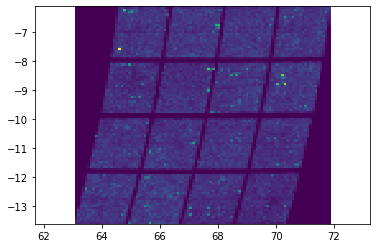

In [26]:
#plt.scatter(zrc["ra"]*np.cos(zrc["dec"]*u.deg.to(u.rad)), zrc["dec"])
plt.hist2d(zgc["ra"]*np.cos(zgc["dec"]*u.deg.to(u.rad)), zgc["dec"], bins=100)
plt.axis('equal')
plt.show()

### Computing a magnitude to error relation

*ErrorMagnitudeRelation* permits to get the median magntiude error for each magnitude.  
For this we bin all the magnitude measurement in one filter and compute the median error for each bin.  
When *get_sigma* is called, it will return the median error value as the typical error for this magnitude.  
We can improve this by interpolating, and taking account the value of the considered measurement itself (in regards of the magnitude bin median error) to create the new error.

In [27]:
class ErrorMagnitudeRelation:
    def __init__(self, df, filters, bin_number=10):
        self.bin_edges = {}
        self.bin_values = {}
        self.filters = filters
        for c in self.filters:
            df[f"bins_{c}"], self.bin_edges[c] = pd.qcut(df[df["filtercode"]==c]['mag'], bin_number, retbins=True)
            self.bin_values[c] = df[df["filtercode"]==c].groupby(f"bins_{c}")["magerr"].agg(np.median).values
            df.drop(columns = f"bins_{c}", inplace=True)

    def get_sigma(self, cfilter, mag):
        """Get median sigma"""
        index = np.digitize(mag, self.bin_edges[cfilter])
        index = np.where(index>=len(self.bin_edges[cfilter])-2, len(self.bin_values[cfilter])-1, index-1)
        return self.bin_values[cfilter][index]

    def vectorized_get_sigma(self, filter_list, mag):
        conds = [filter_list == cfilter for cfilter in self.filters]
        choices=[]
        for cfilter in self.filters:
            index = np.digitize(mag, self.bin_edges[cfilter])
            index = np.where(index>=len(self.bin_edges[cfilter])-2, len(self.bin_values[cfilter])-1, index-1)
            choices.append(self.bin_values[cfilter][index])
        return np.select(conds, choices)
    
    def display(self):
        for c in self.filters:
            eds = self.bin_edges[c]
            vals = self.bin_values[c]
            plt.scatter((eds[:-1]+eds[1:])/2, vals, s=10)
            print(vals)
            plt.ylim(0, np.nanmax(vals))
            plt.title(c)
            plt.xlabel("Magnitude")
            plt.ylabel("Error")
            plt.show()

Takes a few seconds

In [28]:
#%%snakeviz
emr = ErrorMagnitudeRelation(lcs, filters = lcs.filtercode.unique(), bin_number=30)

[0.012 0.011 0.012 0.013 0.015 0.017 0.021 0.025 0.03  0.036 0.043 0.05
 0.058 0.066 0.074 0.083 0.091 0.1   0.109 0.118 0.127 0.136 0.144 0.153
 0.161 0.17  0.181 0.193 0.207 0.229]


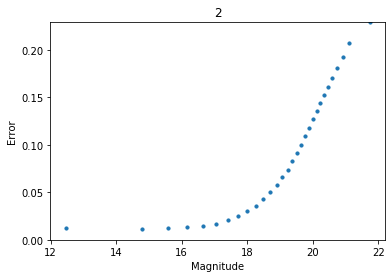

[0.016 0.016 0.016 0.016 0.018 0.019 0.022 0.024 0.028 0.032 0.037 0.042
 0.048 0.054 0.062 0.07  0.078 0.088 0.097 0.108 0.118 0.129 0.139 0.149
 0.159 0.169 0.18  0.191 0.205 0.224]


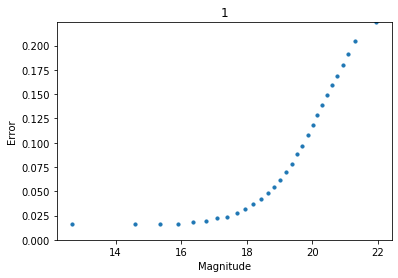

In [29]:
emr.display()

We select light curves with more than 10 total measurements

In [32]:
aid, n, cnt = np.unique(lcs.aid, return_index=True, return_counts=True)

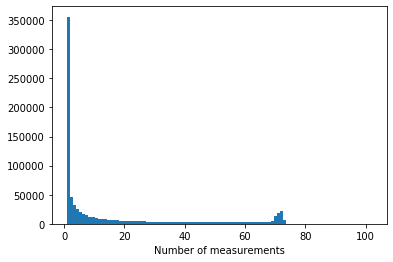

In [46]:
plt.hist(cnt, bins=100)
plt.xlabel("Number of measurements")
plt.show()

In [34]:
lcs = lcs[lcs.aid.isin(aid[cnt>10])]

In [35]:
#lcs = lcs[lcs.aid.isin(np.random.choice(aid[cnt>10], size=10000, replace=False))]

### Simulating the microlensing events 

We generate the microlensing parameters first and then apply the amplification to all data

In [47]:
def mulens_simple(t, mag, u0, t0, tE):
    u = np.sqrt(u0*u0 + ((t-t0)**2)/tE/tE)
    amp = (u**2+2)/(u*np.sqrt(u**2+4))
    return - 2.5*np.log10(amp) + mag

class UniformGenerator:
    def __init__(self, u0_range=[0, 1], tE_range=[10, 500], seed=1234):
        self.u0_range = np.array(u0_range)
        self.tE_range = np.log10(tE_range)
        self.rdm = np.random.RandomState(seed)
    
    def generate_parameters(self, t0_range):
        if len(np.array(t0_range).shape)==1:
            size = None
        else:
            size=len(t0_range[0])
        params = {}
        params["u0"] = self.rdm.uniform(*self.u0_range, size=size)
        params["tE"] = np.power(10, self.rdm.uniform(*self.tE_range, size=size))
        params["t0"] = self.rdm.uniform(t0_range[0], t0_range[1])
        return params

We can select u_0 and t_E parameters ranges here.

In [48]:
ug = UniformGenerator(u0_range=[0, 0.3])

In [49]:
lcs = lcs.sort_values("aid")

In [50]:
lcs["mag_median"] = lcs[["oid", "mag"]].groupby("oid").transform("median")

We generate the parameters :

In [51]:
t0_ranges = lcs.groupby("aid")["hjd"].agg(["max", "min"]).values
params = ug.generate_parameters(t0_range=t0_ranges.T)
_, cnt = np.unique(lcs.aid, return_counts=True)
for key in ["u0", "t0", "tE"]:
    lcs[key]  = np.repeat(params[key], cnt)

We compute the theoretical amplification curve

In [52]:
mag_th = mulens_simple(lcs.hjd.values, lcs.mag_median.values, lcs.u0.values, lcs.t0.values, lcs.tE.values)

We compute the amplifed magnitudes and errorbars

In [53]:
norm = emr.vectorized_get_sigma(lcs.filtercode.values, lcs.mag_median.values) / emr.vectorized_get_sigma(lcs.filtercode.values, mag_th)

In [54]:
lcs["new_magerr"] = lcs["magerr"]/norm

In [55]:
lcs["new_mag"] = mag_th + (lcs["mag"] - lcs["mag_median"]) / norm

We sort the light curve in time to avoid problems with LIA

In [66]:
lcs.sort_values(["aid", "hjd"], inplace=True)

In [68]:
def display_lightcurve(subdf):
    print(subdf.name)
    unique_filters = subdf.filtercode.unique()
    fig, axs = plt.subplots(nrows=len(unique_filters), ncols=1, sharex=True, gridspec_kw={"hspace":0}, squeeze=True)
    if not isinstance(axs, np.ndarray):
        axs = [axs]
    for i, current_filter in enumerate(unique_filters):
        c = subdf[subdf.filtercode == current_filter]
        axs[i].errorbar(c.hjd, c.new_mag, yerr=c.new_magerr, ls='', marker='.', ecolor='k', elinewidth=0.5, color=PLOT_FILTER_COLORS[current_filter])
        axs[i].errorbar(c.hjd, c.mag, yerr=c.magerr, ls='', marker='.', ecolor='k', elinewidth=0.5, color=PLOT_FILTER_COLORS[current_filter], alpha=0.1)
        ts = np.linspace(np.min(c.hjd), np.max(c.hjd), 1000)
        axs[i].plot(ts, mulens_simple(ts, c.mag.median(), c.iloc[0].u0, c.iloc[0].t0, c.iloc[0].tE), color=PLOT_FILTER_COLORS[current_filter])
        axs[i].invert_yaxis()
    plt.show()

Here are some resulting light curve, with the old and amplified data points, and the theoretical microlensing lightcurve.

354101100000000


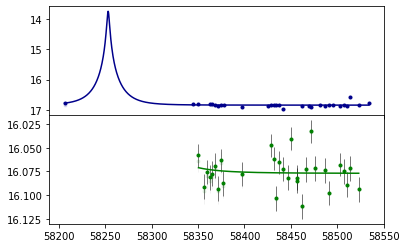

354101100000001


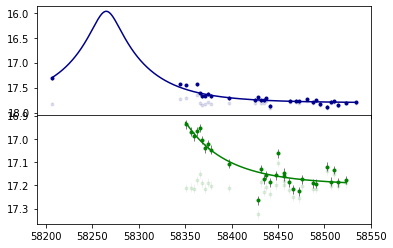

354101100000003


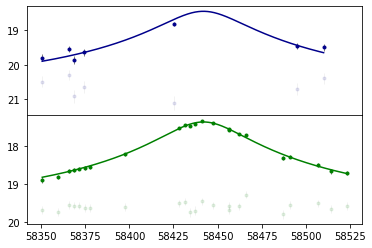

354101100000004


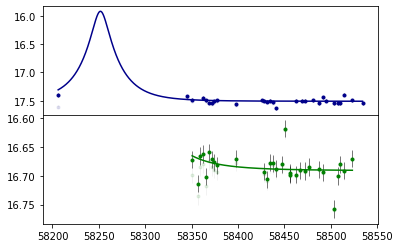

354101100000006


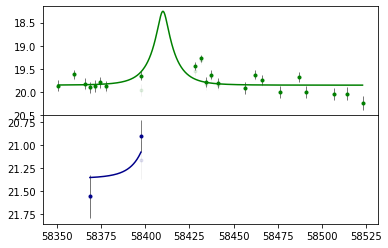

354101100000007


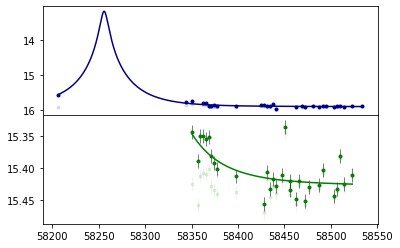

354101100000011


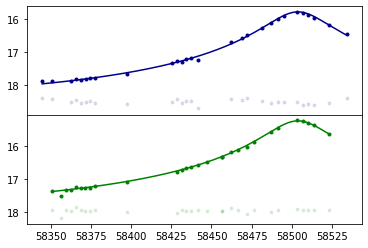

354101100000012


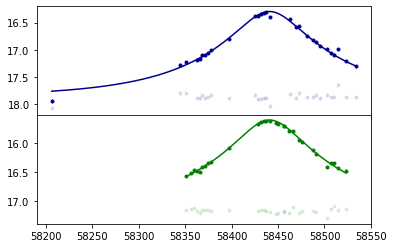

354101100000013


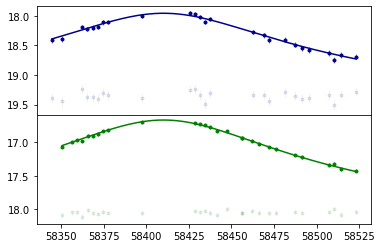

354101100000014


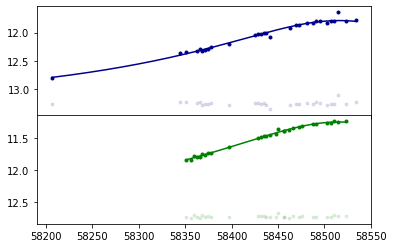

354101100000015


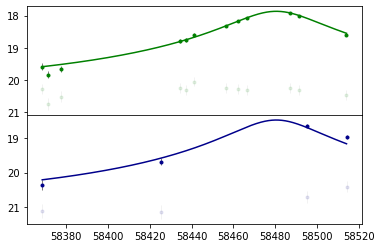

354101100000016


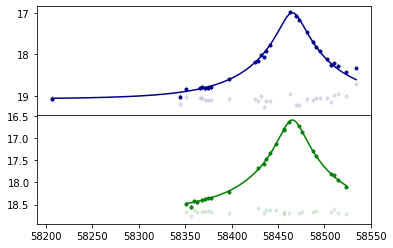

354101100000020


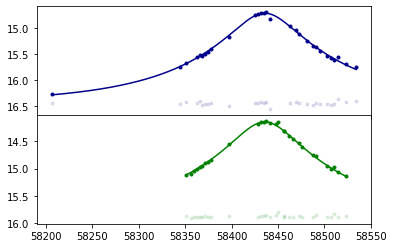

354101100000022


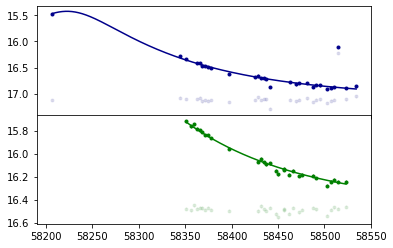

354101100000027


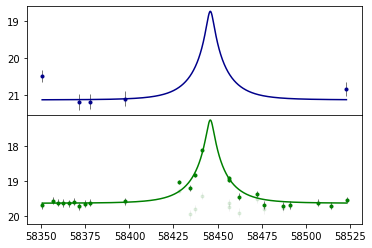

354101100000028


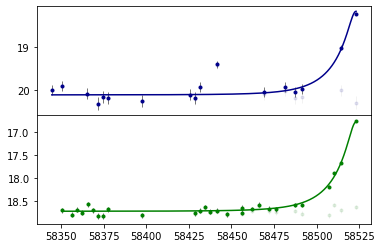

354101100000032


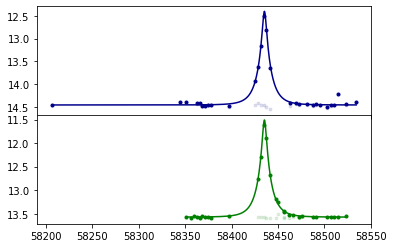

354101100000034


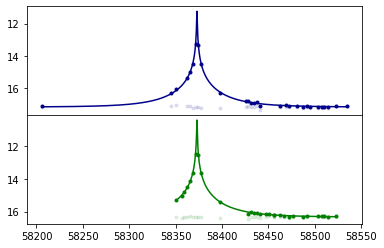

354101100000035


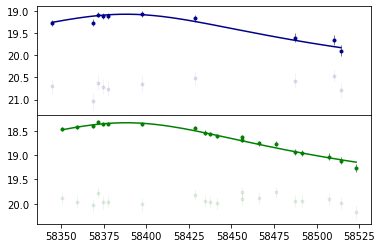

354101100000037


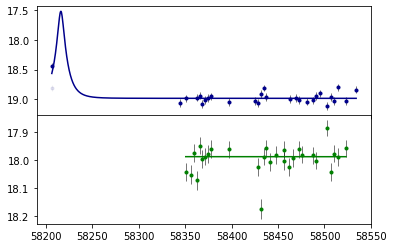

354101100000038


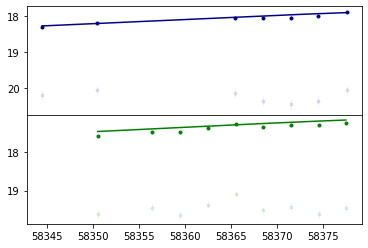

""


In [69]:
lcs.iloc[:1000].groupby("aid").apply(display_lightcurve)

### Saving for the next step

In [41]:
#lcs["filtercode"] = lcs["filtercode"].replace({"zg":1, "zr":2, "zi":3})
lcs.to_csv('lcs.csv', index=False)